#Section 2 - numpy, scipy, and pandas #

**Jonathan Woodring** *Los Alamos National Laboratory*

### modules ###

- *numpy*: provides fast matrix and array operations
- *scipy*: a set of specific analysis tools
- *pandas*: a tabular data model for numpy arrays

### data input/output in this section ###

- *sqlite3*: to and from SQLite data
- *numpy*: to and from binary data

In [1]:
import numpy as np
# the standard name for numpy is np
import numpy 

# of course you can do:
# from numpy import *
# but, lets not

# also, we'll need pyplot
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


# comparing numpy arrays to Python lists #

In [2]:
import time

# two million long lists
A = range(0, 1000000)
B = range(0, 1000000)
# let me preallocate Cl, rather than Cl.append
Cl = [0] * 1000000

# lets time C = A + B (adding two vectors)
start = time.time()
for i in range(0, len(A)):
    Cl[i] = A[i] + B[i]
list_time = time.time() - start

print 'done in %f seconds' % list_time

done in 0.381208 seconds


In [3]:
# C = A + B, with numpy arrays

# initializing A and B from the lists
A = numpy.array(A, numpy.int64)  
B = numpy.array(B, numpy.int64)

# lets time C = A + B, again
start = time.time()
Ca = A + B
array_time = time.time() - start

print 'done in %f seconds' % array_time

done in 0.005960 seconds


In [4]:
# how much faster is numpy?
print 'C = A + B with lists:', list_time
print 'C = A + B with numpy:', array_time
print 'speedup: ' + str(list_time / array_time) + ' times faster'
# just to show they are equal
print 'does Cl == Ca?', numpy.all(Cl == Ca)

C = A + B with lists: 0.381208181381
C = A + B with numpy: 0.00595998764038
speedup: 63.961236899 times faster
does Cl == Ca? True


- Numpy is fast
    1. Uses machine native code, rather than intepreted
    2. Data elements are typed, rather than PyObjects
    3. Vectorization (SIMD)
- Multi-dimensional indexing is more natural: [i,j] vs. [i][j]
- Operations over collections (vectors/arrays) like R and Matlab (implicit vectorization):
    - There's a reason we use Matlab, Fortran, R and Numpy for numerical computing
- Critical mass from the community
    - It's the non-standard "standard" library for all things numerical.

# A simple heat transfer simulation #

A[20,20]: 1e+06


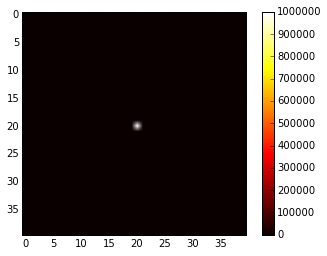

In [5]:
# initialize our 2D array to be 40x40
A = numpy.zeros((40, 40), numpy.float32)

# put a hot spot in the middle
A[20,20] = 1000000.0

# we index with tuples for multi-dimensional arrays
print 'A[20,20]:', A[20,20]

# show initial condition
def show_temp(array):
    plt.figure()
    plt.imshow(array)
    plt.set_cmap('hot')
    plt.colorbar()
    plt.show()
    
# the colors will rescale each time we plot
show_temp(A)

In [6]:
# our little simulation
def iterate(A, steps):
    scale = .5 / 4.0
    # iterate for a bit
    for i in range(0, steps):
        # roll shifts an array on an axis
        left = numpy.roll(A, -1, 0)
        right = numpy.roll(A, 1, 0)
        up = numpy.roll(A, 1, 1)
        down = numpy.roll(A, -1, 1)
        
        # vectorized math
        delta = left + right + up + down - 4 * A
        
        # update A with dh/dt
        A = delta * scale + A

    return A

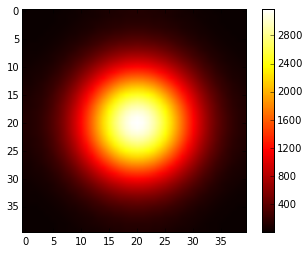

In [7]:
# run it
A = iterate(A, 200)

# show where we ended
show_temp(A)

In [8]:
print A[20, 20] # scalars

print A[20, 20] * A[21, 21]

print numpy.mean(A) # reductions

print numpy.sum(A - .95 * A)

print A*A # element-wise multiply

print A.dot(A) # matrix multiply (numpy.dot(A, A), too)

3183.14
9.93174e+06
625.0
50000.0
[[  16.38537598   18.84791756   27.44467163 ...,   46.08278656
    27.44467545   18.84791756]
 [  18.84791756   21.67605591   31.54674721 ...,   52.93860626
    31.54674721   21.67605591]
 [  27.44467163   31.54674721   45.85525513 ...,   76.8356781    45.85526276
    31.54674721]
 ..., 
 [  46.08278656   52.93860245   76.8356781  ...,  128.51898193   76.8356781
    52.93860626]
 [  27.44467163   31.54674721   45.85525513 ...,   76.8356781    45.85526276
    31.54674721]
 [  18.84791756   21.67605591   31.54674721 ...,   52.93860626
    31.54674721   21.67605591]]
[[ 173429.734375  185506.84375   222377.28125  ...,  285888.3125
   222377.28125   185506.84375 ]
 [ 185506.875     198424.984375  237862.953125 ...,  305796.8125
   237862.96875   198424.984375]
 [ 222377.265625  237862.9375    285139.625    ...,  366575.9375
   285139.65625   237862.96875 ]
 ..., 
 [ 285888.3125    305796.8125    366575.9375   ...,  471270.875
   366575.9375    305796.8125 

# Reading and Writing Binary Data #

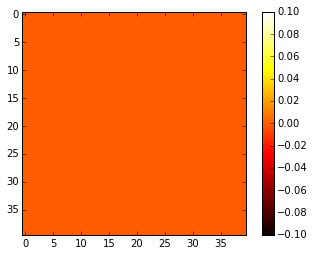

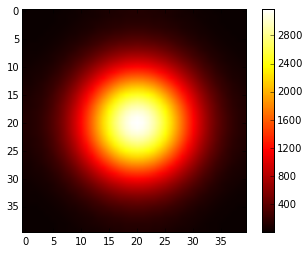

In [9]:
# store the state/checkpoint as a "raw" binary file
A.tofile('A.bin')

# just to show we actual alter B
B = numpy.zeros((40, 40), numpy.float32)
show_temp(B)

# to read A back, have to specify the data type
# and possibily endianess (byte-order)
B = numpy.fromfile('A.bin', numpy.float32)

# we also have to reshape it to the same shape as A
# otherwise B will be a 1D array
B = numpy.reshape(B, (40, 40))

show_temp(B)

True


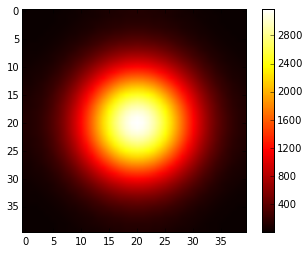

In [10]:
# though if we use numpy's binary format,
# we don't have to worry about shape, type, and endianess
# when we reload it
numpy.save('A.npy', A)
C = numpy.load('A.npy')

# but this does mean if you are sharing binary data
# with another program it has to know how to parse
# .npy -- "raw" binary is easier to share data in the
# short term

print numpy.all((A == B) & (A == C))
show_temp(C)

In [11]:
# struct is one way to read binary if you want
# more control over reading the binary data
# say for instance, reading binary headers
import struct

f = open('A.bin', 'r')

# read 16 bytes and unpack them into 4 floats
print struct.unpack('ffff', f.read(16))

f.close()

(4.047885417938232, 4.341418743133545, 5.238766193389893, 6.7884297370910645)


# Indices and Slices #

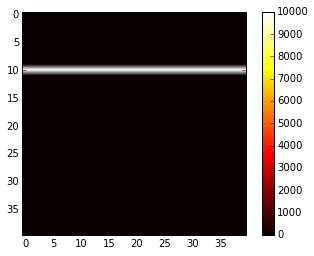

In [12]:
# clear it for now
A = numpy.zeros((40, 40), numpy.float32)

# ":" means all indices in that dimension
# row, column indexing
A[10,:] = 10000.0

show_temp(A)

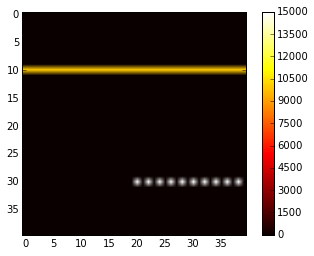

In [13]:
# syntax for a slice is
# start:end:skip where end is non-inclusive
# (i.e., C-style)
A[30,20:40:2] = A[10,10:30:2] * 1.5

show_temp(A)

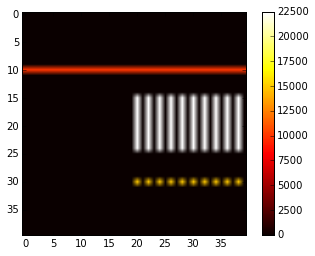

In [14]:
# numpy will "broadcast", i.e., replicate the
# the input, if it is size 1 on a dimension
A[15:25,:] = A[30,:] * 1.5

show_temp(A)

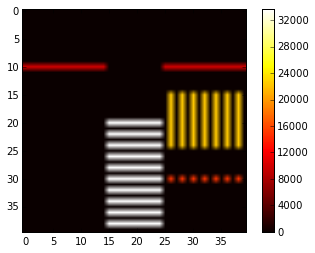

In [15]:
# transpose the input to the output
A[:,15:25] = numpy.transpose(A[15:25,:]) * 1.5

show_temp(A)

# Selections #

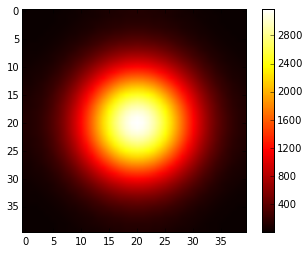

mean: 625.0


In [16]:
# let's load our saved data
A = numpy.load('A.npy')

show_temp(A)

# and get the mean
mean_v = numpy.mean(A)
print 'mean:', mean_v

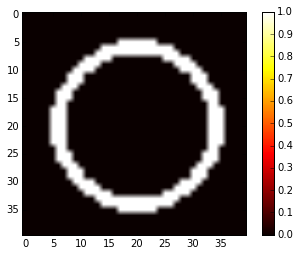

In [17]:
# .5 * mean(A) < A < mean(A)
B = (A < mean_v) & (A > .5 * mean_v)

# this is a boolean array where
# each element is True or False based
# on the condition
show_temp(B)

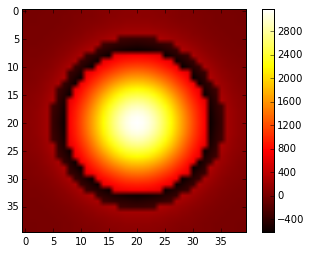

In [18]:
# negate A where B is true
# i.e., B = (A < mean_v) & (A > .5 * mean_v)
A[B] = -A[B]

# we could have also put the expression
# in the brackets, i.e.,
# A = A[(A < mean_v) & (A > .5 * mean_v)]

show_temp(A)

[16 16 16 16 16 17 17 17 17 17 17 17 18 18 18 18 18 18 18 18 18 19 19 19 19
 19 19 19 19 19 20 20 20 20 20 20 20 20 20 21 21 21 21 21 21 21 21 21 22 22
 22 22 22 22 22 22 22 23 23 23 23 23 23 23 24 24 24 24 24]
[18 19 20 21 22 17 18 19 20 21 22 23 16 17 18 19 20 21 22 23 24 16 17 18 19
 20 21 22 23 24 16 17 18 19 20 21 22 23 24 16 17 18 19 20 21 22 23 24 16 17
 18 19 20 21 22 23 24 17 18 19 20 21 22 23 18 19 20 21 22]
16 18


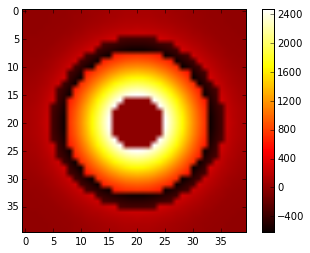

In [19]:
# where is the temp greater than 2500?
I = numpy.where(A > 2500.0)

# I is the indices where it is True
# where I[0] are the is, and I[1] are the js
print I[0]
print I[1]
print I[0][0], I[1][0] # i_0,j_0

# we can modify A with the index array
A[I] = 0.0

# this is equivalent: A[I[0], I[1]] = 0.0

show_temp(A)

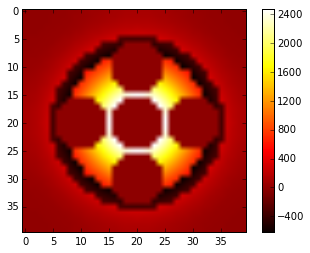

In [20]:
# since I are indices, we can adjust their positions
# and use it to copy that center area around
A[I[0], I[1] + 10] = A[I]
A[I[0], I[1] - 10] = A[I]
A[I[0] + 10, I[1]] = A[I]
A[I[0] - 10, I[1]] = A[I]

show_temp(A)

# Followup numpy resources #

[Link to Numpy Reference](http://docs.scipy.org/doc/numpy/reference/index.html)

- Linear algebra
- Most mathematical functions
- Simple statistics and analysis functions
- Reductions and scans (any, all, sum, prod, etc.)
- Advanced indexing, selection, and set operations
- Masked arrays
- Interfacing with C/Cython
- Creating your own vectorized functions and reductions
- Many other features, check out the [reference](http://docs.scipy.org/doc/numpy/reference/index.html)

# Reading SQLite Data #

In [21]:
# for next section, we'll need some sqlite this time around
import sqlite3

# get a database connection and a "cursor"
conn = sqlite3.connect('GOOG.sqlite3')
cursor = conn.cursor()

# now we can execute SQL on the database
cursor.execute('SELECT name, sql FROM sqlite_master WHERE type="table"')

# and get data from the cursor
i = cursor.next()
print i[0]
print i[1]

GOOG
CREATE TABLE GOOG (adj_close real, close real, date datetime, high real, low real, open real, volume integer)


In [22]:
# a useful module is sqlalchemy for interacting with many
# databases, but here I am just going to use raw SQL code
cursor.execute('SELECT date, close - open FROM GOOG WHERE close > open * 1.07')

# the cursor is iterable
# dates where Google closed 7% higher and by how much
for i in cursor:
    print i

(u'2004-08-20 00:00:00', 7.299999999999997)
(u'2004-11-11 00:00:00', 13.890000000000015)
(u'2008-10-13 00:00:00', 25.22999999999996)
(u'2008-10-28 00:00:00', 29.69999999999999)


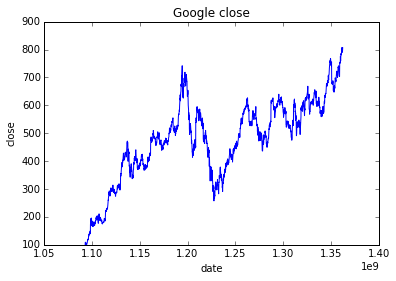

In [23]:
# a helper function to convert SQL data to numpy arrays
def query(cursor, command, dtype):
    cursor.execute(command)
    return numpy.array([i[0] for i in cursor], dtype)

# get our data vectors
X = query(cursor, 'SELECT date FROM GOOG', numpy.datetime64)
Y = query(cursor, 'SELECT close FROM GOOG', numpy.float32)

# plot the data
plt.figure() 
plt.xlabel('date') 
plt.ylabel('close')
plt.plot(X, Y) 
plt.title('Google close')
plt.show()

# scipy #

Both provide a bunch of specialized functionality that base numpy doesn't have.

[Link to scipy reference](http://docs.scipy.org/doc/scipy/reference/)

- Advanced linear algebra
- Integration
- Interpolation
- FFT
- Advanced statistics (doesn't beat **R**, though. You can use *rpy2* to use R in Python.)
- Optimization and regression
- Clustering
- Signal and image processing
- and more...

# Polynomial Fit #

In [24]:
# let's fit the Google stock to a curve
import scipy.optimize as optimize

# convert dates to integers for ease
X = numpy.array(X, numpy.int64)

# our linear model
# scipy.optimize uses introspection to figure 
# out the number of model parameters
def poly(x, a, b):
    return a + b*x

# do a least squares fit
ab, cov = optimize.curve_fit(poly, X, Y) 

# ab are the model parameters, and cov is covariance matrix
print 'model parameters:', ab
print 'covariance matrix:\n', cov

model parameters: [ -1.33559029e+03   1.47552798e-06]
covariance matrix:
[[  9.45503434e+02  -7.67253771e-07]
 [ -7.67253771e-07   6.25103031e-16]]


In [25]:
# to plot the curve, we need to create 
# a fixed function from our parameters
import functools

# this will freeze the model with our parameters
# (this is a partial application or a "closure")
fixed = functools.partial(poly, a=ab[0], b=ab[1])

# fixed is now a function of one free parameter
# whereas poly was originally 3 free parameters
print fixed
print 'model at x_0:', fixed(X[0])

model at x_0: 277.007156926


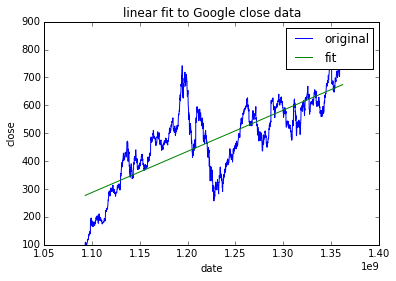

In [26]:
# plot the linear fit with the data
plt.figure() 
plt.plot(X, Y) 

# this is the model curve
plt.plot(X, fixed(X)) 

# labels
plt.xlabel('date') 
plt.ylabel('close')
plt.legend(['original', 'fit'])
plt.title('linear fit to Google close data')
plt.show()

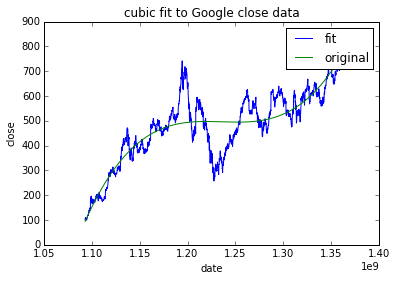

In [27]:
# we can even do cubic fitting
# just add more parameters to your model curve
def poly(x, a, b, c, d):
    return a + b * x + c * x * x + d * x * x * x

# do the optimization and "freezing" the function
ab, cov = optimize.curve_fit(poly, X, Y) 
fixed = functools.partial(poly, a=ab[0], b=ab[1], c=ab[2], d=ab[3])

# plot everything
plt.figure() 
plt.plot(X, Y) 
plt.plot(X, fixed(X)) 
plt.xlabel('date') 
plt.ylabel('close')
plt.legend(['fit', 'original'])
plt.title('cubic fit to Google close data')
plt.show()

# Power Spectrum #

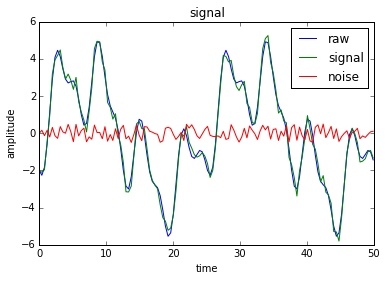

In [28]:
# time samples
delta = numpy.pi / 8
time = numpy.arange(0, 16 * numpy.pi, delta)

# a made up signal
raw = numpy.sin(time * 2 + numpy.pi) +\
    numpy.sin(time - numpy.pi * .5) * 2 +\
    numpy.sin(time * .25) * 3

# some noise
noise = (numpy.random.rand(time.size) - .5)

# our noisy signal 
signal = raw + noise
    
# let's plot it
plt.figure()
plt.plot(time, raw)
plt.plot(time, signal) 
plt.plot(time, noise)
plt.title('signal')
plt.xlabel('time')
plt.ylabel('amplitude')
plt.legend(['raw', 'signal', 'noise'])
plt.show()

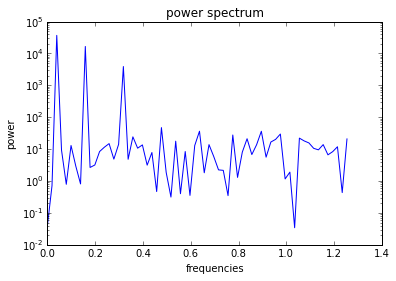

In [29]:
# let's do some Fourier analysis
from scipy import fftpack

# standard definition of power spectrum
power = numpy.abs(fftpack.fft(signal)) ** 2

# frequencies from sampling spacing
freqs = fftpack.fftfreq(time.size, delta)

# sorted indices of the frequencies
i = numpy.argsort(freqs)
i = i[freqs[i] >= 0]

power = power[i]
freqs = freqs[i]

# let's plot it
plt.figure()
plt.plot(freqs, power) 
plt.title('power spectrum')
plt.xlabel('frequencies')
plt.ylabel('power')
plt.yscale('log')
plt.show()

# Convolution #

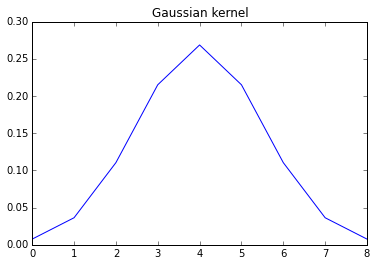

In [30]:
# let's smooth the signal
from scipy.signal import gaussian

# gaussian kernel of 9 width, stddev of 1.5
kernel = gaussian(9, 1.5)
area = numpy.trapz(kernel)
kernel = kernel / area

# plot the kernel
plt.figure() 
plt.plot(kernel) 
plt.title('Gaussian kernel')
plt.show()

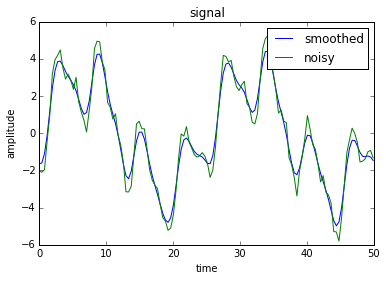

In [31]:
# convolution
from scipy.signal import convolve

# pad the signal on both ends
smooth = numpy.concatenate([signal[-4:], signal, signal[:4]])

# convolve it
smooth = convolve(smooth, kernel, 'valid')

# plot the data
plt.figure() 
plt.plot(time, smooth) 
plt.plot(time, signal)
plt.title('signal')
plt.xlabel('time')
plt.ylabel('amplitude')
plt.legend(['smoothed', 'noisy'])
plt.show()

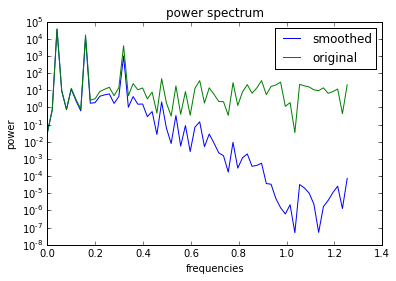

In [32]:
# power spectrum again
smooth_power = numpy.abs(fftpack.fft(smooth)) ** 2
smooth_power = smooth_power[i]

# comparison of the two power spectra
plt.figure()
plt.plot(freqs, smooth_power)
plt.plot(freqs, power) 
plt.title('power spectrum')
plt.xlabel('frequencies')
plt.ylabel('power')
plt.yscale('log')
plt.legend(['smoothed', 'original'])
plt.show()

# Writing data to SQLite #

In [33]:
# we'll create a new database
conn = sqlite3.connect('signals.sqlite3')
cursor = conn.cursor()

# and a table to store our data in it
cursor.execute('CREATE TABLE signal (time real, raw real, smooth real)')

# now we just have to insert all of the data into it
for i, j, k in zip(time, signal, smooth):
    cursor.execute('INSERT INTO signal VALUES (?, ?, ?)', (i, j, k))
    
conn.commit() # commit the transactions

In [34]:
# now we can query the data
cursor.execute('SELECT time FROM signal WHERE abs(raw - smooth) > 1')

# the times where the smooth signal
# deviates from the original by 1
for i in cursor:
    print i[0]

7.06858347058
38.4845100065
40.0553063333
44.7676953137


# pandas #

[Link to pandas reference](http://pandas.pydata.org/pandas-docs/stable/)

- Provides "data frames," which are similar to **R** data frames
    - Has functionality similar to plyr/dplyr
    - i.e., some DSL for SQL-like queries without SQL
- Provides tabular representations of your numpy, dict, and list data
- A useful syntax addition on top of numpy for doing complex data slicing and selection
- Easy input and output to tabular/columnar data formats
    - Direct to and from CSV, HDF, SQLite, etc.

In [35]:
# we'll sqlachemy this time around
# which can also connect to other databases
import sqlalchemy
engine = sqlalchemy.create_engine("sqlite:///iris.sqlite3")

# pandas knows how to read a table using sqlachemy
import pandas
import pandas as pd # this is typical

iris = pandas.read_sql_table("iris", engine)
print iris.columns

# this is a table/pandas Data Frame)
iris.head() # there is also .tail()

Index([u'index', u'Unnamed: 0', u'SepalLength', u'SepalWidth', u'PetalLength', u'PetalWidth', u'Species'], dtype='object')


,index,Unnamed: 0,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
0,0,1,5.1,3.5,1.4,0.2,setosa
1,1,2,4.9,3.0,1.4,0.2,setosa
2,2,3,4.7,3.2,1.3,0.2,setosa
3,3,4,4.6,3.1,1.5,0.2,setosa
4,4,5,5.0,3.6,1.4,0.2,setosa


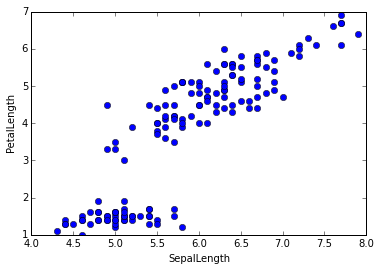

In [36]:
# we can plot the data
def show_iris(iris, x, y):
    plt.figure()
    # select two columns (a Series in pandas parlance)
    plt.plot(iris[x], iris[y], 'o')
    plt.xlabel(x)
    plt.ylabel(y)
    
show_iris(iris, 'SepalLength', 'PetalLength')

In [37]:
# selecting multiple columns by a list of column names
iris = iris[['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth', 'Species']]
iris.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
10,5.4,3.7,1.5,0.2,setosa
20,5.4,3.4,1.7,0.2,setosa
30,4.8,3.1,1.6,0.2,setosa
40,5.0,3.5,1.3,0.3,setosa
50,7.0,3.2,4.7,1.4,versicolor


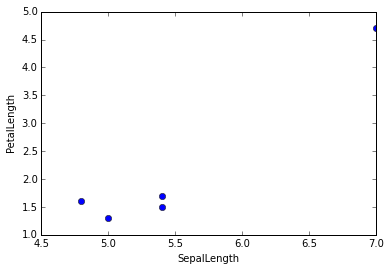

In [38]:
# [] is overloaded to also do index selection
# i.e., row selection
sel = iris[10:51:10]

show_iris(sel, 'SepalLength', 'PetalLength')
sel

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
50,7.0,3.2,4.7,1.4,versicolor
51,6.4,3.2,4.5,1.5,versicolor
52,6.9,3.1,4.9,1.5,versicolor
53,5.5,2.3,4.0,1.3,versicolor
54,6.5,2.8,4.6,1.5,versicolor


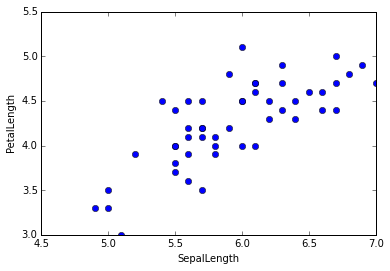

In [39]:
# with [] you can also boolean select
sel = iris[iris.Species == 'versicolor']

show_iris(sel, 'SepalLength', 'PetalLength')
sel.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
57,4.9,2.4,3.3,1.0,versicolor
60,5.0,2.0,3.5,1.0,versicolor
64,5.6,2.9,3.6,1.3,versicolor
79,5.7,2.6,3.5,1.0,versicolor
80,5.5,2.4,3.8,1.1,versicolor
81,5.5,2.4,3.7,1.0,versicolor
93,5.0,2.3,3.3,1.0,versicolor
98,5.1,2.5,3.0,1.1,versicolor


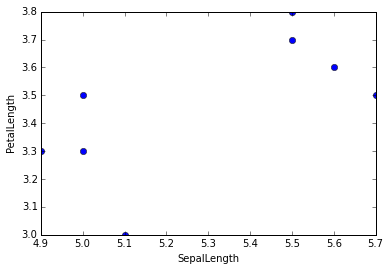

In [40]:
# and use multiple columns in your query
sel = iris[(iris.Species == 'versicolor') & (iris.PetalLength < 3.9)]

show_iris(sel, 'SepalLength', 'PetalLength')
sel

In [41]:
# we can change any column to be an index
iris.index = iris.Species
iris.head()

# there is also multi-dimensional indexing,
# for N-D indexing, but we won't go into that

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
Species,,,,,
setosa,5.1,3.5,1.4,0.2,setosa
setosa,4.9,3.0,1.4,0.2,setosa
setosa,4.7,3.2,1.3,0.2,setosa
setosa,4.6,3.1,1.5,0.2,setosa
setosa,5.0,3.6,1.4,0.2,setosa


,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
Species,,,,,
setosa,5.1,3.5,1.4,0.2,setosa
setosa,5.0,3.0,1.6,0.2,setosa
versicolor,7.0,3.2,4.7,1.4,versicolor
versicolor,6.6,3.0,4.4,1.4,versicolor
virginica,6.3,3.3,6.0,2.5,virginica
virginica,7.2,3.2,6.0,1.8,virginica


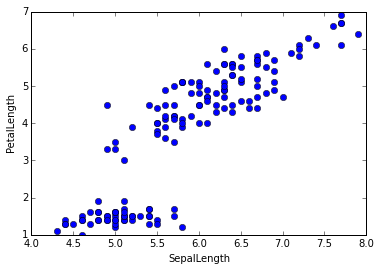

In [42]:
# then that means you can do indexing by labels
# label indexing in pandas is right-inclusive
# i.e., different from list/array slicing
sel = iris['setosa':'virginica']

show_iris(sel, 'SepalLength', 'PetalLength')
sel[::25]

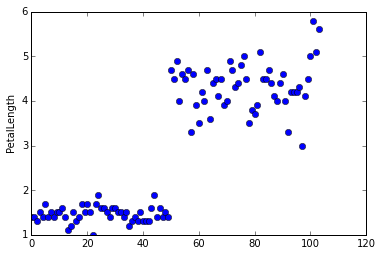

In [43]:
# to do more explicit selection, use 
# .loc, .iloc, and .ix (labels, integers, mixed)

# this selects a column (a Series in pandas parlance)
# i.e., datapanel.loc[row(s), column(s)]
sel = iris.loc[iris.PetalWidth < 1.8, 'PetalLength']

plt.figure()
plt.plot(sel, 'o')
plt.ylabel('PetalLength')
plt.show()

,PetalLength,SepalLength
Species,,
setosa,1.4,5.1
setosa,1.4,4.9
setosa,1.3,4.7
setosa,1.5,4.6
setosa,1.4,5.0


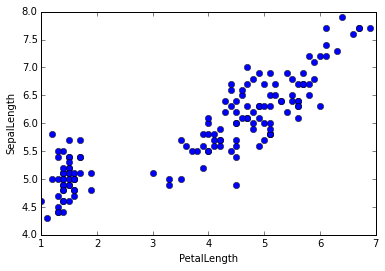

In [44]:
# you can also do multiple rows and columns
sel = iris.loc[:,['PetalLength', 'SepalLength']]

show_iris(sel, 'PetalLength', 'SepalLength')
sel.head()

In [45]:
# as you can see, pandas is very SQL-like/R-like
# and you can even do aggregation
sel = iris.groupby('Species')
sel.aggregate(numpy.mean)

,SepalLength,SepalWidth,PetalLength,PetalWidth
Species,,,,
setosa,5.006,3.428,1.462,0.246
versicolor,5.936,2.770,4.260,1.326
virginica,6.588,2.974,5.552,2.026


,PetalWidth,PetalLength
Species,,
versicolor,1.5,4.9
virginica,2.3,6.9


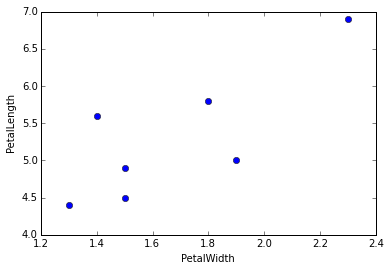

In [46]:
# and do something like
B = (iris.SepalLength > 6.0) & (iris.SepalWidth < 2.7)
sel = iris.loc[B,['Species', 'PetalWidth', 'PetalLength']]

show_iris(iris[B], 'PetalWidth', 'PetalLength')
sel.groupby('Species').aggregate(numpy.max)

In [47]:
# you can even do joins
df = pandas.DataFrame({'Species': ['versicolor', 'virginica'], 'researcher': ['Roger', 'Jane']})

sel = pandas.merge(iris, df, on='Species')
sel[::15]

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species,researcher
0,7.0,3.2,4.7,1.4,versicolor,Roger
15,6.7,3.1,4.4,1.4,versicolor,Roger
30,5.5,2.4,3.8,1.1,versicolor,Roger
45,5.7,3.0,4.2,1.2,versicolor,Roger
60,6.5,3.2,5.1,2.0,virginica,Jane
75,7.2,3.2,6.0,1.8,virginica,Jane
90,6.7,3.1,5.6,2.4,virginica,Jane


In [48]:
# and when you are all done, output the data back to
# SQLite (or any other database with sqlalchemy)

engine = sqlalchemy.create_engine('sqlite:///select.sqlite3')
sel.to_sql('select', engine)

copy = pandas.read_sql_table('select', engine)
copy[::15]

,index,SepalLength,SepalWidth,PetalLength,PetalWidth,Species,researcher
0,0,7.0,3.2,4.7,1.4,versicolor,Roger
15,15,6.7,3.1,4.4,1.4,versicolor,Roger
30,30,5.5,2.4,3.8,1.1,versicolor,Roger
45,45,5.7,3.0,4.2,1.2,versicolor,Roger
60,60,6.5,3.2,5.1,2.0,virginica,Jane
75,75,7.2,3.2,6.0,1.8,virginica,Jane
90,90,6.7,3.1,5.6,2.4,virginica,Jane
